In [1]:
import os
from google.colab import userdata

os.environ["ROBOFLOW_API_KEY"] = "XarTw09VRJncVEPwvwBe"

In [2]:
!nvidia-smi

Sun Jun  1 03:19:18 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   64C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [4]:
!pip install -q git+https://github.com/sunsmarterjie/yolov12.git roboflow supervision flash-attn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [5]:
!wget https://media.roboflow.com/notebooks/examples/dog.jpeg

--2025-06-01 03:19:34--  https://media.roboflow.com/notebooks/examples/dog.jpeg
Resolving media.roboflow.com (media.roboflow.com)... 34.110.133.209
Connecting to media.roboflow.com (media.roboflow.com)|34.110.133.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106055 (104K) [image/jpeg]
Saving to: ‘dog.jpeg.2’

dog.jpeg.2          100%[===================>] 103.57K  --.-KB/s    in 0.001s  

2025-06-01 03:19:34 (91.6 MB/s) - ‘dog.jpeg.2’ saved [106055/106055]



FlashAttention is not available on this device. Using scaled_dot_product_attention instead.


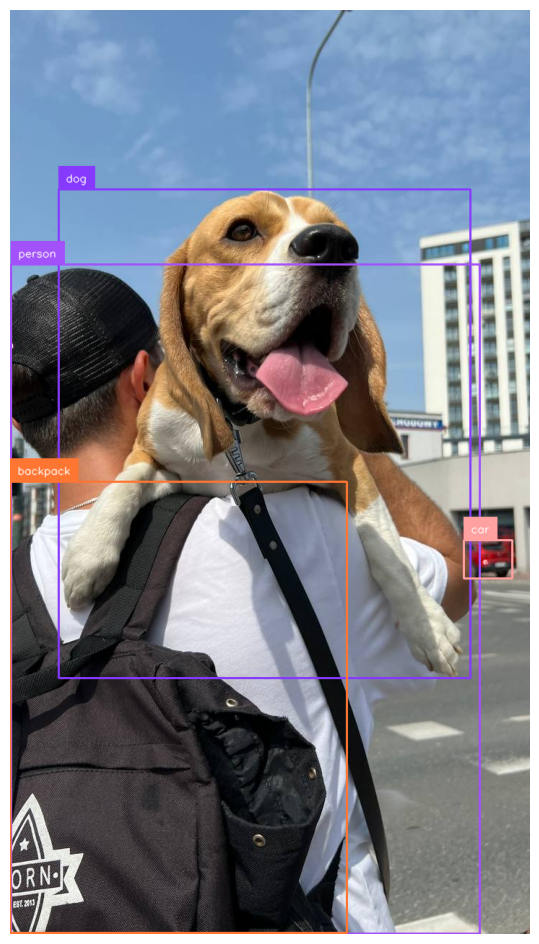

In [6]:
import cv2
from ultralytics import YOLO
import supervision as sv


image_path = f"{HOME}/dog.jpeg"
image = cv2.imread(image_path)

model = YOLO('yolov12l.pt')

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results)

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

In [7]:
from roboflow import download_dataset
dataset = download_dataset('https://universe.roboflow.com/roboflow-100/road-signs-6ih4y/dataset/2', 'yolov8')

loading Roboflow workspace...
loading Roboflow project...


In [8]:
!ls {dataset.location}

data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid


In [9]:
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

In [10]:
!cat {dataset.location}/data.yaml

names:
- bus_stop
- do_not_enter
- do_not_stop
- do_not_turn_l
- do_not_turn_r
- do_not_u_turn
- enter_left_lane
- green_light
- left_right_lane
- no_parking
- parking
- ped_crossing
- ped_zebra_cross
- railway_crossing
- red_light
- stop
- t_intersection_l
- traffic_light
- u_turn
- warning
- yellow_light
nc: 21
roboflow:
  license: CC BY 4.0
  project: road-signs-6ih4y
test: ../test/images
train: ../train/images
val: ../valid/images


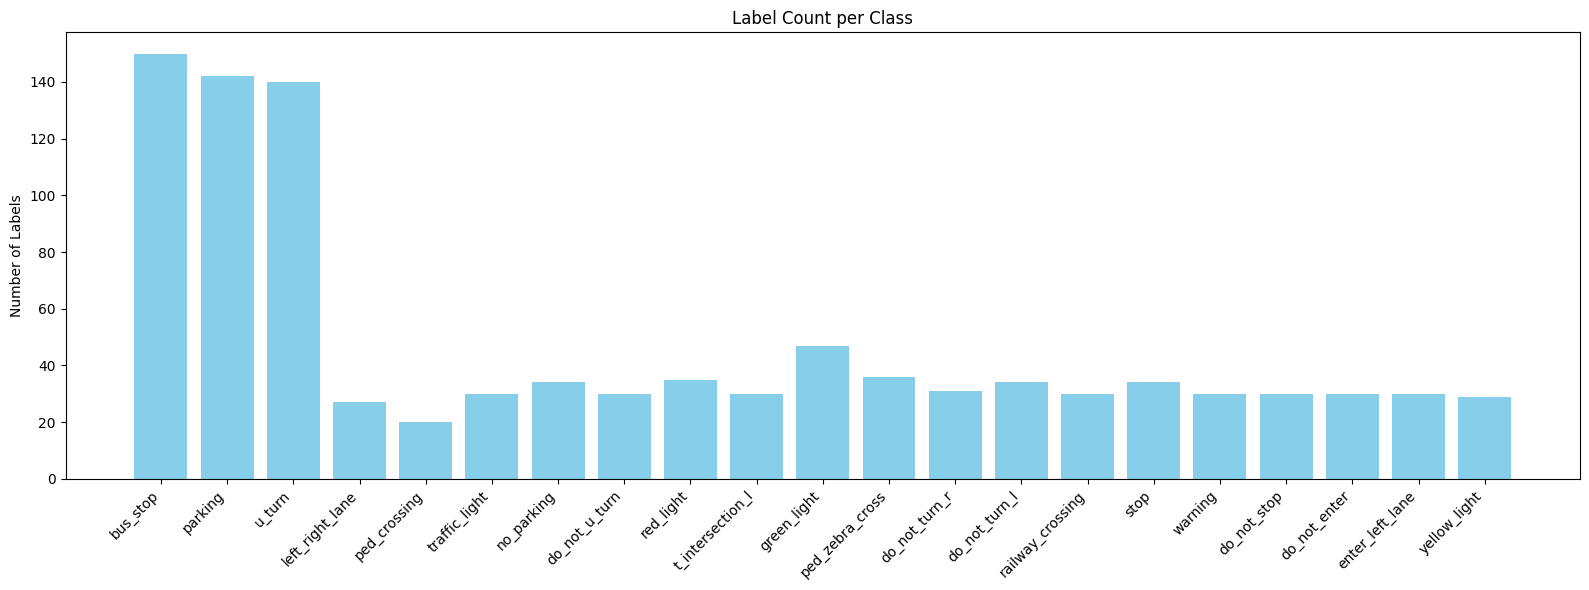

In [11]:
import os
import matplotlib.pyplot as plt
from collections import defaultdict

# class names
names = [
    'bus_stop', 'do_not_enter', 'do_not_stop', 'do_not_turn_l', 'do_not_turn_r',
    'do_not_u_turn', 'enter_left_lane', 'green_light', 'left_right_lane', 'no_parking',
    'parking', 'ped_crossing', 'ped_zebra_cross', 'railway_crossing', 'red_light',
    'stop', 't_intersection_l', 'traffic_light', 'u_turn', 'warning', 'yellow_light'
]

# 路徑設定
split_dirs = ['/content/road-signs-2/test/labels', '/content/road-signs-2/valid/labels', '/content/road-signs-2/test/labels']
label_counts = defaultdict(int)

# 逐個資料夾讀取標註檔
for dir_path in split_dirs:
    if not os.path.exists(dir_path):
        continue
    for file_name in os.listdir(dir_path):
        if not file_name.endswith('.txt'):
            continue
        with open(os.path.join(dir_path, file_name), 'r') as f:
            lines = f.readlines()
            for line in lines:
                class_id = int(line.split()[0])
                label_counts[class_id] += 1

# 將 class_id 映射為名字
category_counts = {names[class_id]: count for class_id, count in label_counts.items()}

# 確保所有類別都顯示（即使為 0）
for name in names:
    category_counts.setdefault(name, 0)

# 畫直方圖
plt.figure(figsize=(16, 6))
plt.bar(category_counts.keys(), category_counts.values(), color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Number of Labels")
plt.title("Label Count per Class")
plt.tight_layout()
plt.show()

In [12]:
from ultralytics import YOLO

model = YOLO('yolo11s.pt')

results = model.train(data=f'{dataset.location}/data.yaml', epochs=200)

New https://pypi.org/project/ultralytics/8.3.146 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=/content/road-signs-2/data.yaml, epochs=200, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_

train: Scanning /content/road-signs-2/train/labels.cache... 1376 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1376/1376 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


A new version of Albumentations is available: '2.0.8' (you have '2.0.7'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
Argument(s) 'quality_lower' are not valid for transform ImageCompression
val: Scanning /content/road-signs-2/valid/labels.cache... 488 images, 0 backgrounds, 0 corrupt: 100%|██████████| 488/488 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.0004, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200      4.39G      1.063      4.397      1.302         38        640: 100%|██████████| 86/86 [00:30<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.32it/s]

                   all        488        529      0.523      0.532      0.537      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200      4.37G     0.9499      2.052       1.17         33        640: 100%|██████████| 86/86 [00:29<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.92it/s]

                   all        488        529       0.58      0.653      0.647      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200      4.37G     0.9166      1.429       1.13         41        640: 100%|██████████| 86/86 [00:27<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.48it/s]

                   all        488        529      0.694      0.724      0.754      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200      4.37G     0.9291      1.258      1.149         29        640: 100%|██████████| 86/86 [00:28<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.22it/s]

                   all        488        529      0.731      0.703      0.763      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200      4.37G     0.8933       1.14      1.122         26        640: 100%|██████████| 86/86 [00:27<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.32it/s]


                   all        488        529      0.892      0.775      0.878      0.698

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200      4.37G     0.8859       1.03      1.118         25        640: 100%|██████████| 86/86 [00:27<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.49it/s]

                   all        488        529      0.758       0.77      0.821      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200      4.37G     0.8706     0.9708      1.104         33        640: 100%|██████████| 86/86 [00:27<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.95it/s]

                   all        488        529      0.794      0.855      0.864      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200      4.37G     0.8668      0.942      1.095         31        640: 100%|██████████| 86/86 [00:27<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.50it/s]

                   all        488        529      0.831      0.827      0.891      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200      4.37G     0.8578     0.9031      1.099         35        640: 100%|██████████| 86/86 [00:28<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.08it/s]

                   all        488        529       0.87      0.816      0.893      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200      4.36G      0.821     0.8773      1.087         34        640: 100%|██████████| 86/86 [00:27<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.38it/s]

                   all        488        529      0.879      0.863      0.906      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200      4.37G     0.8394     0.8497      1.082         36        640: 100%|██████████| 86/86 [00:27<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.50it/s]

                   all        488        529      0.881      0.853       0.92       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200      4.36G     0.8138     0.7746      1.073         29        640: 100%|██████████| 86/86 [00:27<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.02it/s]

                   all        488        529      0.878      0.866      0.908      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200      4.37G     0.7963     0.7612      1.058         40        640: 100%|██████████| 86/86 [00:27<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.52it/s]

                   all        488        529      0.869      0.871      0.918      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200      4.36G     0.7979     0.7664      1.064         31        640: 100%|██████████| 86/86 [00:28<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.06it/s]

                   all        488        529      0.883      0.825      0.899       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200      4.37G     0.7935     0.7595      1.063         24        640: 100%|██████████| 86/86 [00:27<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.54it/s]

                   all        488        529      0.893      0.847      0.927      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200      4.36G     0.7954     0.7479      1.074         30        640: 100%|██████████| 86/86 [00:27<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.47it/s]

                   all        488        529      0.895      0.852      0.923      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200      4.37G     0.7821     0.7063      1.048         29        640: 100%|██████████| 86/86 [00:27<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.98it/s]

                   all        488        529       0.88       0.89      0.935      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200      4.36G     0.7798     0.6718      1.055         35        640: 100%|██████████| 86/86 [00:27<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.55it/s]

                   all        488        529      0.899      0.908      0.935      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200      4.37G     0.7656     0.6681      1.049         27        640: 100%|██████████| 86/86 [00:27<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.01it/s]

                   all        488        529      0.888      0.879      0.929      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200      4.36G     0.7628     0.6812      1.041         32        640: 100%|██████████| 86/86 [00:27<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.52it/s]

                   all        488        529      0.923      0.891       0.94      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200      4.37G     0.7589     0.6694      1.031         27        640: 100%|██████████| 86/86 [00:28<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.15it/s]

                   all        488        529      0.878       0.89      0.925      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200      4.36G     0.7301     0.6532      1.022         35        640: 100%|██████████| 86/86 [00:27<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.25it/s]

                   all        488        529      0.904      0.891      0.939      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200      4.37G     0.7426     0.6364      1.033         37        640: 100%|██████████| 86/86 [00:27<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.51it/s]

                   all        488        529      0.901      0.914       0.94      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200      4.36G     0.7361     0.6459       1.03         29        640: 100%|██████████| 86/86 [00:28<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.99it/s]

                   all        488        529      0.912      0.893      0.933      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200      4.37G     0.7242     0.6461      1.029         41        640: 100%|██████████| 86/86 [00:27<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.54it/s]

                   all        488        529      0.912      0.903      0.939      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200      4.36G     0.7349      0.625      1.027         33        640: 100%|██████████| 86/86 [00:27<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.08it/s]

                   all        488        529      0.933      0.904      0.948      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200      4.37G      0.739     0.6035      1.021         40        640: 100%|██████████| 86/86 [00:27<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.28it/s]


                   all        488        529      0.906      0.903      0.927      0.772

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200      4.36G     0.7323     0.6147      1.031         36        640: 100%|██████████| 86/86 [00:27<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.53it/s]

                   all        488        529      0.933      0.913      0.947      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200      4.37G     0.7349     0.5898      1.017         36        640: 100%|██████████| 86/86 [00:27<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.04it/s]

                   all        488        529      0.921      0.897      0.938      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200      4.36G     0.7337     0.6169      1.027         34        640: 100%|██████████| 86/86 [00:28<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.54it/s]

                   all        488        529      0.894      0.934      0.948      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200      4.37G     0.7012     0.5785      1.019         31        640: 100%|██████████| 86/86 [00:27<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.01it/s]

                   all        488        529      0.918      0.907      0.936      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200      4.36G     0.7091     0.5661      1.017         22        640: 100%|██████████| 86/86 [00:27<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.56it/s]

                   all        488        529      0.908      0.917       0.95      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200      4.37G     0.7153     0.5817      1.028         29        640: 100%|██████████| 86/86 [00:28<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.46it/s]

                   all        488        529      0.875      0.877      0.916      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200      4.36G      0.717     0.5855      1.026         34        640: 100%|██████████| 86/86 [00:27<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.99it/s]

                   all        488        529      0.894      0.918      0.937       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200      4.38G     0.6943     0.5568     0.9996         29        640: 100%|██████████| 86/86 [00:27<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.51it/s]

                   all        488        529      0.908      0.922      0.953      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200      4.35G     0.7003     0.5342      1.006         28        640: 100%|██████████| 86/86 [00:27<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.00it/s]

                   all        488        529      0.951      0.893      0.961      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200      4.37G     0.7147     0.5689      1.017         36        640: 100%|██████████| 86/86 [00:27<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.50it/s]

                   all        488        529      0.899      0.865      0.941      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200      4.37G     0.7003     0.5521      1.003         26        640: 100%|██████████| 86/86 [00:27<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.32it/s]

                   all        488        529       0.92      0.911      0.942      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200      4.37G     0.6981     0.5729      1.012         25        640: 100%|██████████| 86/86 [00:27<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.31it/s]


                   all        488        529      0.929      0.881      0.936      0.777

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200      4.36G     0.6873     0.5332      1.006         28        640: 100%|██████████| 86/86 [00:27<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.50it/s]

                   all        488        529      0.919       0.91      0.948       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200      4.37G     0.6983      0.572      1.002         39        640: 100%|██████████| 86/86 [00:27<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.07it/s]

                   all        488        529      0.941       0.91      0.958      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200      4.36G     0.6799     0.5474     0.9975         34        640: 100%|██████████| 86/86 [00:27<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.52it/s]

                   all        488        529       0.93      0.885      0.934       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200      4.37G     0.6879     0.5436      1.004         33        640: 100%|██████████| 86/86 [00:27<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.98it/s]

                   all        488        529      0.914       0.91      0.953      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200      4.36G     0.6751     0.5278     0.9994         28        640: 100%|██████████| 86/86 [00:27<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.56it/s]

                   all        488        529      0.929      0.876       0.95      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200      4.37G     0.6712      0.518     0.9927         36        640: 100%|██████████| 86/86 [00:27<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.91it/s]

                   all        488        529      0.931      0.919      0.956      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200      4.36G     0.6596     0.5095     0.9936         23        640: 100%|██████████| 86/86 [00:27<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.54it/s]

                   all        488        529       0.93      0.935      0.958      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200      4.36G     0.6858     0.5052      1.004         30        640: 100%|██████████| 86/86 [00:28<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.45it/s]

                   all        488        529      0.937      0.927      0.961      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200      4.36G     0.6697     0.5173      1.005         38        640: 100%|██████████| 86/86 [00:27<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.15it/s]

                   all        488        529      0.904       0.93      0.952      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200      4.37G     0.6563     0.5067     0.9912         32        640: 100%|██████████| 86/86 [00:27<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.52it/s]

                   all        488        529      0.924      0.903      0.943      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200      4.36G     0.6413     0.5107     0.9795         28        640: 100%|██████████| 86/86 [00:27<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.07it/s]

                   all        488        529      0.933      0.933      0.955      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200      4.37G      0.656     0.4967     0.9869         34        640: 100%|██████████| 86/86 [00:27<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.57it/s]

                   all        488        529      0.929      0.922      0.952        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200      4.36G     0.6579     0.5076      0.986         27        640: 100%|██████████| 86/86 [00:27<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.04it/s]

                   all        488        529      0.933      0.931      0.961      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200      4.37G     0.6259     0.4948     0.9745         36        640: 100%|██████████| 86/86 [00:27<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.48it/s]

                   all        488        529      0.938      0.943      0.961      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200      4.36G     0.6494     0.4969     0.9872         28        640: 100%|██████████| 86/86 [00:28<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.13it/s]

                   all        488        529      0.934      0.935      0.956      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200      4.37G      0.647     0.4959     0.9846         38        640: 100%|██████████| 86/86 [00:27<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.34it/s]


                   all        488        529      0.946      0.934      0.958      0.801

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200      4.36G      0.648     0.4991     0.9835         31        640: 100%|██████████| 86/86 [00:27<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.50it/s]

                   all        488        529      0.928      0.944      0.959      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/200      4.37G     0.6353     0.4787     0.9785         42        640: 100%|██████████| 86/86 [00:27<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.11it/s]

                   all        488        529      0.941      0.937      0.961      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200      4.36G     0.6454     0.4736     0.9793         31        640: 100%|██████████| 86/86 [00:27<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.48it/s]

                   all        488        529      0.935      0.932       0.95      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200      4.37G     0.6401     0.4697     0.9851         32        640: 100%|██████████| 86/86 [00:28<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.97it/s]

                   all        488        529      0.937      0.914       0.95      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200      4.36G     0.6463     0.4931     0.9842         39        640: 100%|██████████| 86/86 [00:28<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.48it/s]

                   all        488        529      0.925      0.926       0.95        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200      4.37G     0.6301     0.4742     0.9739         26        640: 100%|██████████| 86/86 [00:28<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.34it/s]

                   all        488        529      0.967      0.925      0.961      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200      4.36G      0.611     0.4554     0.9761         27        640: 100%|██████████| 86/86 [00:28<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.98it/s]


                   all        488        529       0.93      0.932      0.955      0.815

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/200      4.37G     0.6195     0.4613     0.9716         31        640: 100%|██████████| 86/86 [00:28<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.47it/s]

                   all        488        529      0.935      0.933      0.957      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/200      4.36G     0.6168     0.4626     0.9737         30        640: 100%|██████████| 86/86 [00:28<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.08it/s]

                   all        488        529      0.954       0.93       0.96      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/200      4.37G      0.624      0.481     0.9779         20        640: 100%|██████████| 86/86 [00:27<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.48it/s]

                   all        488        529      0.939      0.911      0.959      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/200      4.36G     0.6168     0.4527      0.967         35        640: 100%|██████████| 86/86 [00:27<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.46it/s]

                   all        488        529      0.959      0.926      0.964      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/200      4.37G     0.6217     0.4619     0.9778         32        640: 100%|██████████| 86/86 [00:27<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.18it/s]


                   all        488        529      0.959      0.924      0.965      0.819

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/200      4.36G     0.6215     0.4538     0.9678         37        640: 100%|██████████| 86/86 [00:27<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.55it/s]

                   all        488        529      0.935      0.927      0.963      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/200      4.37G     0.6205     0.4382     0.9686         26        640: 100%|██████████| 86/86 [00:27<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.97it/s]

                   all        488        529      0.932      0.923      0.956      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/200      4.36G     0.6074     0.4423     0.9619         23        640: 100%|██████████| 86/86 [00:27<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.55it/s]

                   all        488        529      0.927      0.932      0.963      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/200      4.37G     0.5918     0.4373      0.955         26        640: 100%|██████████| 86/86 [00:27<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.14it/s]

                   all        488        529      0.942      0.922      0.958      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/200      4.36G     0.6175     0.4518     0.9745         33        640: 100%|██████████| 86/86 [00:27<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.57it/s]

                   all        488        529      0.929      0.916      0.944      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/200      4.37G     0.5981     0.4402      0.961         40        640: 100%|██████████| 86/86 [00:28<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.35it/s]

                   all        488        529      0.939      0.918      0.949      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/200      4.37G     0.6049     0.4394     0.9598         25        640: 100%|██████████| 86/86 [00:27<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.11it/s]

                   all        488        529      0.929      0.934      0.957      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/200      4.37G     0.5858     0.4236     0.9559         31        640: 100%|██████████| 86/86 [00:27<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.59it/s]

                   all        488        529      0.958      0.928      0.961       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/200      4.37G     0.5966     0.4295     0.9544         32        640: 100%|██████████| 86/86 [00:27<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.00it/s]

                   all        488        529      0.942      0.927       0.96       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/200      4.37G      0.593     0.4331     0.9653         25        640: 100%|██████████| 86/86 [00:27<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.52it/s]

                   all        488        529      0.941      0.911      0.958      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/200      4.36G     0.5757     0.4271     0.9572         33        640: 100%|██████████| 86/86 [00:27<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.13it/s]

                   all        488        529      0.917      0.907      0.939      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/200      4.37G     0.6067     0.4509     0.9681         36        640: 100%|██████████| 86/86 [00:27<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.48it/s]


                   all        488        529      0.943      0.942      0.962      0.814

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/200      4.36G     0.5896     0.4288     0.9613         32        640: 100%|██████████| 86/86 [00:27<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.54it/s]

                   all        488        529        0.9      0.955      0.972       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/200      4.37G     0.5795     0.4242     0.9581         32        640: 100%|██████████| 86/86 [00:27<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.00it/s]


                   all        488        529      0.922      0.931      0.963      0.816

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/200      4.36G     0.5724     0.4012     0.9577         28        640: 100%|██████████| 86/86 [00:27<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.43it/s]

                   all        488        529       0.93      0.931      0.955      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/200      4.37G     0.5739     0.4279     0.9546         32        640: 100%|██████████| 86/86 [00:27<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.04it/s]

                   all        488        529      0.934      0.934      0.957      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/200      4.36G     0.5682     0.4204     0.9525         39        640: 100%|██████████| 86/86 [00:28<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.56it/s]

                   all        488        529      0.942       0.91      0.953      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/200      4.37G     0.5811     0.4043     0.9577         38        640: 100%|██████████| 86/86 [00:28<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.16it/s]

                   all        488        529      0.929      0.929      0.957      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/200      4.36G      0.561     0.4043     0.9507         29        640: 100%|██████████| 86/86 [00:27<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.56it/s]

                   all        488        529      0.942      0.934      0.963      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/200      4.37G     0.5706     0.4175       0.95         41        640: 100%|██████████| 86/86 [00:27<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.39it/s]

                   all        488        529      0.951      0.923      0.963      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/200      4.37G      0.568     0.4049     0.9449         35        640: 100%|██████████| 86/86 [00:27<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.13it/s]


                   all        488        529      0.943      0.918      0.951      0.804

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/200      4.37G     0.5545      0.394     0.9545         30        640: 100%|██████████| 86/86 [00:27<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.57it/s]

                   all        488        529      0.953      0.927      0.962      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/200      4.36G       0.55     0.3854     0.9361         31        640: 100%|██████████| 86/86 [00:27<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.06it/s]

                   all        488        529       0.94      0.922       0.96      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/200      4.36G     0.5572     0.3981     0.9449         35        640: 100%|██████████| 86/86 [00:27<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.49it/s]

                   all        488        529      0.924      0.934      0.961      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/200      4.36G     0.5594     0.3947     0.9491         32        640: 100%|██████████| 86/86 [00:27<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.99it/s]

                   all        488        529      0.959      0.915      0.948      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/200      4.37G     0.5548     0.3968     0.9531         35        640: 100%|██████████| 86/86 [00:27<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.57it/s]

                   all        488        529      0.933       0.92      0.957      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/200      4.36G     0.5572     0.3996     0.9498         35        640: 100%|██████████| 86/86 [00:27<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.00it/s]

                   all        488        529      0.947      0.938      0.968       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/200      4.37G     0.5541     0.3985     0.9414         28        640: 100%|██████████| 86/86 [00:27<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.51it/s]

                   all        488        529      0.941      0.931      0.966      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/200      4.36G     0.5486     0.3988     0.9487         32        640: 100%|██████████| 86/86 [00:27<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.31it/s]

                   all        488        529      0.953      0.925      0.965      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/200      4.37G     0.5462     0.4006      0.942         35        640: 100%|██████████| 86/86 [00:27<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.36it/s]

                   all        488        529      0.936      0.957      0.966       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/200      4.37G      0.555     0.3977     0.9454         22        640: 100%|██████████| 86/86 [00:27<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.55it/s]

                   all        488        529       0.93      0.934      0.962      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/200      4.37G     0.5354     0.3775     0.9406         41        640: 100%|██████████| 86/86 [00:27<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.12it/s]


                   all        488        529      0.946      0.923      0.959      0.814

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/200      4.36G     0.5369      0.393     0.9348         40        640: 100%|██████████| 86/86 [00:27<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.57it/s]

                   all        488        529      0.931      0.923      0.947      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/200      4.37G      0.541     0.3785     0.9392         25        640: 100%|██████████| 86/86 [00:27<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.04it/s]

                   all        488        529      0.947      0.928      0.955      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/200      4.36G     0.5243     0.3714     0.9332         26        640: 100%|██████████| 86/86 [00:27<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.54it/s]

                   all        488        529      0.939      0.926      0.962      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/200      4.37G     0.5292     0.3703     0.9404         38        640: 100%|██████████| 86/86 [00:27<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.07it/s]

                   all        488        529      0.934      0.924      0.955      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/200      4.36G     0.5243     0.3825     0.9367         33        640: 100%|██████████| 86/86 [00:27<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.60it/s]

                   all        488        529      0.927      0.938      0.959      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/200      4.37G     0.5431     0.3867     0.9355         30        640: 100%|██████████| 86/86 [00:27<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.23it/s]

                   all        488        529       0.92      0.947      0.962      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/200      4.36G     0.5148      0.361     0.9315         30        640: 100%|██████████| 86/86 [00:27<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.45it/s]


                   all        488        529      0.931       0.93      0.953      0.809

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/200      4.37G     0.5451     0.3812     0.9449         29        640: 100%|██████████| 86/86 [00:27<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.53it/s]

                   all        488        529      0.941      0.933       0.96      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/200      4.36G     0.5242     0.3695     0.9347         28        640: 100%|██████████| 86/86 [00:27<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.18it/s]


                   all        488        529      0.955      0.921      0.963      0.821

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/200      4.37G     0.5257     0.3718     0.9327         37        640: 100%|██████████| 86/86 [00:27<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.51it/s]

                   all        488        529       0.95      0.924      0.957      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/200      4.36G     0.5232     0.3606     0.9317         36        640: 100%|██████████| 86/86 [00:27<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.04it/s]

                   all        488        529      0.931      0.936      0.954      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/200      4.37G     0.5096     0.3756     0.9313         31        640: 100%|██████████| 86/86 [00:27<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.59it/s]

                   all        488        529      0.941      0.928       0.96      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/200      4.37G     0.4932     0.3457     0.9225         33        640: 100%|██████████| 86/86 [00:27<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.99it/s]

                   all        488        529      0.945      0.937      0.963      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/200      4.37G     0.5109     0.3581     0.9302         33        640: 100%|██████████| 86/86 [00:27<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.50it/s]

                   all        488        529       0.96      0.944      0.966       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/200      4.36G     0.5146      0.362     0.9332         29        640: 100%|██████████| 86/86 [00:27<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.25it/s]

                   all        488        529      0.939      0.944      0.961      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/200      4.37G     0.4993     0.3511     0.9274         32        640: 100%|██████████| 86/86 [00:27<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.55it/s]

                   all        488        529      0.932       0.95      0.965      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/200      4.36G     0.5057      0.353     0.9229         38        640: 100%|██████████| 86/86 [00:27<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.37it/s]

                   all        488        529      0.932      0.928      0.958      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/200      4.37G     0.4992     0.3569     0.9317         27        640: 100%|██████████| 86/86 [00:27<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.19it/s]


                   all        488        529      0.925       0.93      0.958      0.816

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/200      4.36G     0.5023     0.3463     0.9205         33        640: 100%|██████████| 86/86 [00:27<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.53it/s]

                   all        488        529      0.952      0.924      0.961      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/200      4.37G     0.5173      0.368     0.9295         26        640: 100%|██████████| 86/86 [00:27<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.04it/s]

                   all        488        529      0.949      0.931      0.964      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/200      4.37G      0.503     0.3575     0.9236         24        640: 100%|██████████| 86/86 [00:27<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.62it/s]

                   all        488        529      0.956      0.919      0.967      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/200      4.37G     0.4914     0.3447     0.9232         46        640: 100%|██████████| 86/86 [00:27<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.10it/s]

                   all        488        529      0.943      0.941      0.968      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/200      4.37G     0.4927     0.3544     0.9303         32        640: 100%|██████████| 86/86 [00:27<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.56it/s]

                   all        488        529      0.953      0.934      0.966      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/200      4.37G      0.506     0.3511     0.9295         34        640: 100%|██████████| 86/86 [00:27<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.16it/s]

                   all        488        529      0.946      0.937      0.965      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/200      4.35G      0.494     0.3535     0.9308         34        640: 100%|██████████| 86/86 [00:27<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.40it/s]

                   all        488        529       0.95      0.947       0.97      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/200      4.37G     0.4901     0.3403     0.9228         27        640: 100%|██████████| 86/86 [00:27<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.51it/s]

                   all        488        529      0.933      0.943      0.966      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/200      4.36G     0.4841     0.3438     0.9203         38        640: 100%|██████████| 86/86 [00:27<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.07it/s]

                   all        488        529      0.959      0.924      0.969      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/200      4.37G     0.4944     0.3393     0.9278         40        640: 100%|██████████| 86/86 [00:27<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.52it/s]

                   all        488        529      0.938      0.937      0.958      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/200      4.36G     0.4841     0.3275     0.9185         37        640: 100%|██████████| 86/86 [00:27<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.01it/s]

                   all        488        529      0.927      0.938      0.959      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/200      4.37G     0.4878      0.345     0.9148         34        640: 100%|██████████| 86/86 [00:27<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.54it/s]

                   all        488        529      0.939      0.922       0.96       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/200      4.36G     0.4835     0.3381     0.9176         33        640: 100%|██████████| 86/86 [00:27<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.09it/s]

                   all        488        529      0.942      0.937       0.96      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/200      4.37G     0.4944     0.3455     0.9261         33        640: 100%|██████████| 86/86 [00:27<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.56it/s]

                   all        488        529      0.951      0.932      0.964      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/200      4.36G     0.4786      0.331     0.9147         20        640: 100%|██████████| 86/86 [00:27<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.40it/s]

                   all        488        529       0.94      0.943      0.966      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/200      4.37G     0.4805     0.3261     0.9194         29        640: 100%|██████████| 86/86 [00:27<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.25it/s]

                   all        488        529       0.95      0.922       0.96      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/200      4.36G      0.473     0.3234     0.9132         32        640: 100%|██████████| 86/86 [00:27<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.57it/s]

                   all        488        529      0.946      0.926      0.957      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/200      4.37G     0.4673     0.3251     0.9132         39        640: 100%|██████████| 86/86 [00:27<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.09it/s]

                   all        488        529      0.933      0.941      0.963      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/200      4.36G     0.4763     0.3176     0.9193         37        640: 100%|██████████| 86/86 [00:27<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.57it/s]

                   all        488        529      0.932      0.921      0.961       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/200      4.37G     0.4648     0.3156     0.9157         32        640: 100%|██████████| 86/86 [00:27<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.97it/s]

                   all        488        529      0.944      0.927      0.964      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/200      4.36G     0.4557     0.3179     0.9079         34        640: 100%|██████████| 86/86 [00:27<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.54it/s]

                   all        488        529      0.931      0.949      0.968       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/200      4.37G      0.468     0.3334     0.9129         36        640: 100%|██████████| 86/86 [00:28<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.16it/s]

                   all        488        529      0.955       0.91       0.96      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/200      4.36G     0.4599     0.3217     0.9057         26        640: 100%|██████████| 86/86 [00:27<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.55it/s]

                   all        488        529      0.908      0.937      0.952      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/200      4.37G     0.4581     0.3278     0.9122         37        640: 100%|██████████| 86/86 [00:28<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.29it/s]

                   all        488        529      0.937      0.925      0.957      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/200      4.36G     0.4737      0.318     0.9234         29        640: 100%|██████████| 86/86 [00:27<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.32it/s]


                   all        488        529      0.924      0.931      0.959      0.822

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/200      4.37G     0.4518     0.3207     0.9116         31        640: 100%|██████████| 86/86 [00:27<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.53it/s]

                   all        488        529      0.943       0.93      0.952      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/200      4.36G     0.4575     0.3108     0.9098         43        640: 100%|██████████| 86/86 [00:27<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.12it/s]

                   all        488        529      0.957      0.926       0.96      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/200      4.37G     0.4492     0.2987     0.9118         35        640: 100%|██████████| 86/86 [00:27<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.54it/s]

                   all        488        529      0.947      0.929      0.955      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/200      4.36G      0.454     0.3092     0.9116         41        640: 100%|██████████| 86/86 [00:27<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.00it/s]

                   all        488        529      0.934      0.941      0.963      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/200      4.37G     0.4377     0.3059     0.9051         33        640: 100%|██████████| 86/86 [00:27<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.55it/s]

                   all        488        529      0.938      0.945      0.968      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/200      4.37G     0.4496     0.3102     0.9105         26        640: 100%|██████████| 86/86 [00:27<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.12it/s]

                   all        488        529       0.93      0.948      0.964      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/200      4.37G     0.4392     0.3132     0.9105         25        640: 100%|██████████| 86/86 [00:27<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.55it/s]

                   all        488        529      0.928      0.942      0.966      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/200      4.36G     0.4371     0.3034     0.9045         35        640: 100%|██████████| 86/86 [00:27<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.21it/s]

                   all        488        529      0.924      0.955      0.963      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/200      4.37G     0.4332     0.3069     0.9075         33        640: 100%|██████████| 86/86 [00:27<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.20it/s]

                   all        488        529      0.939      0.939      0.962      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/200      4.36G     0.4544      0.305     0.9133         28        640: 100%|██████████| 86/86 [00:27<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.55it/s]

                   all        488        529      0.945      0.933      0.967      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/200      4.37G     0.4378     0.2974     0.9104         25        640: 100%|██████████| 86/86 [00:27<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.00it/s]

                   all        488        529      0.939       0.94      0.965      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/200      4.36G     0.4353      0.293     0.9025         43        640: 100%|██████████| 86/86 [00:27<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.58it/s]

                   all        488        529       0.94      0.949      0.968      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/200      4.37G     0.4402     0.3088     0.9115         28        640: 100%|██████████| 86/86 [00:27<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.04it/s]

                   all        488        529      0.952      0.924      0.965      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/200      4.36G     0.4348     0.2918     0.9039         30        640: 100%|██████████| 86/86 [00:27<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.58it/s]

                   all        488        529      0.956      0.921      0.963      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/200      4.37G     0.4311     0.3074     0.9041         33        640: 100%|██████████| 86/86 [00:28<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.12it/s]

                   all        488        529      0.941      0.935      0.963      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/200      4.36G     0.4255     0.2886     0.8976         29        640: 100%|██████████| 86/86 [00:27<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.45it/s]


                   all        488        529      0.914      0.949      0.964      0.831

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/200      4.37G     0.4336     0.3036     0.9024         28        640: 100%|██████████| 86/86 [00:28<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.48it/s]

                   all        488        529      0.942      0.917      0.964      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/200      4.36G     0.4258     0.2956     0.9031         34        640: 100%|██████████| 86/86 [00:27<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.97it/s]


                   all        488        529      0.931      0.926      0.961      0.827

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/200      4.37G     0.4188     0.2972     0.8954         29        640: 100%|██████████| 86/86 [00:27<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.54it/s]

                   all        488        529      0.915      0.948      0.959      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/200      4.36G     0.4199     0.2926     0.9061         42        640: 100%|██████████| 86/86 [00:28<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.99it/s]

                   all        488        529      0.937      0.928      0.964      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/200      4.37G     0.4163     0.2844      0.894         28        640: 100%|██████████| 86/86 [00:28<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.57it/s]

                   all        488        529      0.939      0.935       0.96      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/200      4.36G     0.4156     0.2893     0.9042         26        640: 100%|██████████| 86/86 [00:28<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.28it/s]

                   all        488        529      0.947      0.929      0.964      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/200      4.36G     0.4001      0.278     0.8922         26        640: 100%|██████████| 86/86 [00:27<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.34it/s]


                   all        488        529       0.93      0.938      0.961      0.826

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/200      4.36G     0.4079     0.2851     0.8998         32        640: 100%|██████████| 86/86 [00:27<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.41it/s]

                   all        488        529      0.922      0.944      0.961      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/200      4.37G     0.4104     0.2805     0.9003         35        640: 100%|██████████| 86/86 [00:27<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.04it/s]

                   all        488        529      0.918      0.952       0.96      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/200      4.36G     0.4129      0.281     0.8951         25        640: 100%|██████████| 86/86 [00:27<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.52it/s]

                   all        488        529      0.922      0.941      0.963      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/200      4.36G     0.4086     0.2843     0.8956         44        640: 100%|██████████| 86/86 [00:28<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.96it/s]

                   all        488        529      0.931      0.939      0.963      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/200      4.36G     0.4102     0.2853     0.8961         32        640: 100%|██████████| 86/86 [00:28<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.48it/s]

                   all        488        529      0.945      0.917      0.957      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/200      4.37G     0.4083     0.2813     0.8934         29        640: 100%|██████████| 86/86 [00:28<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.07it/s]

                   all        488        529      0.905      0.938       0.95      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/200      4.36G     0.3988      0.272     0.8982         22        640: 100%|██████████| 86/86 [00:28<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.44it/s]

                   all        488        529       0.93      0.928      0.956      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/200      4.37G     0.4087     0.2699     0.8994         33        640: 100%|██████████| 86/86 [00:27<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.48it/s]

                   all        488        529      0.947      0.927      0.961      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/200      4.36G     0.3937     0.2697     0.8907         31        640: 100%|██████████| 86/86 [00:27<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.11it/s]


                   all        488        529       0.95      0.918      0.961      0.827

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/200      4.37G     0.3864     0.2618     0.8884         35        640: 100%|██████████| 86/86 [00:27<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.50it/s]

                   all        488        529      0.931      0.941       0.96      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/200      4.37G     0.4007     0.2741     0.8927         27        640: 100%|██████████| 86/86 [00:27<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.96it/s]

                   all        488        529      0.955       0.92      0.958      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/200      4.37G     0.3921     0.2671     0.8952         31        640: 100%|██████████| 86/86 [00:28<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.50it/s]

                   all        488        529      0.941      0.929      0.958      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/200      4.36G     0.3999     0.2723     0.8987         28        640: 100%|██████████| 86/86 [00:28<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.11it/s]

                   all        488        529      0.942      0.923      0.957      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/200      4.36G     0.3812     0.2603     0.8861         35        640: 100%|██████████| 86/86 [00:28<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.24it/s]

                   all        488        529      0.954      0.916      0.956      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/200      4.36G     0.4033     0.2721     0.8955         39        640: 100%|██████████| 86/86 [00:28<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.52it/s]

                   all        488        529      0.922      0.935      0.958      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/200      4.37G     0.3782     0.2606     0.8841         30        640: 100%|██████████| 86/86 [00:27<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.05it/s]

                   all        488        529      0.949       0.91       0.96      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/200      4.37G     0.3811     0.2632     0.8841         38        640: 100%|██████████| 86/86 [00:27<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.54it/s]

                   all        488        529      0.925      0.935       0.96      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/200      4.36G     0.3871     0.2611     0.8934         34        640: 100%|██████████| 86/86 [00:27<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.95it/s]

                   all        488        529      0.931      0.936      0.961      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/200      4.36G     0.3962     0.2642     0.8893         33        640: 100%|██████████| 86/86 [00:27<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.60it/s]

                   all        488        529      0.933      0.939      0.961      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/200      4.37G     0.3838     0.2623      0.888         31        640: 100%|██████████| 86/86 [00:28<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.21it/s]

                   all        488        529      0.956      0.918      0.962      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/200      4.36G     0.3808     0.2596     0.8852         29        640: 100%|██████████| 86/86 [00:27<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.35it/s]


                   all        488        529      0.956      0.921      0.963      0.823

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/200      4.37G     0.3849     0.2698     0.8918         25        640: 100%|██████████| 86/86 [00:28<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.51it/s]

                   all        488        529      0.944       0.93      0.963      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/200      4.36G      0.383     0.2659     0.8943         32        640: 100%|██████████| 86/86 [00:27<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.03it/s]

                   all        488        529      0.935      0.931       0.96      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/200      4.37G     0.3782     0.2654      0.892         32        640: 100%|██████████| 86/86 [00:27<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.46it/s]

                   all        488        529      0.939       0.93       0.96      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/200      4.37G     0.3725     0.2613     0.8871         32        640: 100%|██████████| 86/86 [00:27<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.97it/s]

                   all        488        529      0.942      0.931       0.96      0.824


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/200      4.36G     0.3124     0.1771     0.8215         16        640: 100%|██████████| 86/86 [00:28<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.45it/s]

                   all        488        529      0.943      0.929      0.961      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/200      4.35G     0.2918      0.168     0.8101         18        640: 100%|██████████| 86/86 [00:27<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.39it/s]

                   all        488        529      0.922      0.941      0.959      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/200      4.36G     0.2897      0.166     0.8109         17        640: 100%|██████████| 86/86 [00:27<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.12it/s]

                   all        488        529      0.918      0.939      0.961      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/200      4.35G     0.2886     0.1631     0.8204         19        640: 100%|██████████| 86/86 [00:27<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.52it/s]

                   all        488        529      0.916      0.941       0.96      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/200      4.36G     0.2851     0.1659     0.8079         19        640: 100%|██████████| 86/86 [00:27<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.04it/s]

                   all        488        529      0.915      0.951      0.961      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/200      4.35G      0.287     0.1677     0.8114         19        640: 100%|██████████| 86/86 [00:27<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.56it/s]

                   all        488        529      0.925      0.944      0.962      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/200      4.36G     0.2879     0.1648     0.8156         18        640: 100%|██████████| 86/86 [00:27<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.04it/s]

                   all        488        529      0.919      0.949      0.963      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/200      4.35G     0.2818     0.1632     0.8141         16        640: 100%|██████████| 86/86 [00:27<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.45it/s]

                   all        488        529      0.937      0.929      0.962      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/200      4.36G     0.2851      0.163     0.8104         16        640: 100%|██████████| 86/86 [00:27<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.10it/s]

                   all        488        529      0.926      0.941      0.961      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/200      4.35G     0.2785     0.1633     0.8145         18        640: 100%|██████████| 86/86 [00:27<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.56it/s]

                   all        488        529      0.934      0.937      0.961      0.824



200 epochs completed in 1.871 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 19.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 19.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 238 layers, 9,420,927 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.18it/s]


                   all        488        529      0.914      0.949      0.964      0.831
          do_not_enter         30         30      0.889          1      0.994      0.941
           do_not_stop         30         30      0.868      0.967      0.965      0.906
         do_not_turn_l         30         34      0.948      0.971      0.994      0.911
         do_not_turn_r         30         31      0.906      0.938      0.976      0.934
         do_not_u_turn         30         30      0.967      0.963      0.968      0.846
       enter_left_lane         30         30      0.943          1      0.995      0.892
           green_light         30         47      0.909      0.894      0.955      0.774
       left_right_lane          9          9      0.908          1      0.995      0.963
            no_parking         30         34      0.846      0.941      0.975      0.876
       ped_zebra_cross         30         36      0.978          1      0.995      0.836
      railway_crossin

In [13]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!ls {HOME}/runs/detect/train/

args.yaml					    train_batch16340.jpg
confusion_matrix_normalized.png			    train_batch16341.jpg
confusion_matrix.png				    train_batch16342.jpg
events.out.tfevents.1748747993.578aa82b736a.5602.0  train_batch1.jpg
F1_curve.png					    train_batch2.jpg
labels_correlogram.jpg				    val_batch0_labels.jpg
labels.jpg					    val_batch0_pred.jpg
P_curve.png					    val_batch1_labels.jpg
PR_curve.png					    val_batch1_pred.jpg
R_curve.png					    val_batch2_labels.jpg
results.csv					    val_batch2_pred.jpg
results.png					    weights
train_batch0.jpg


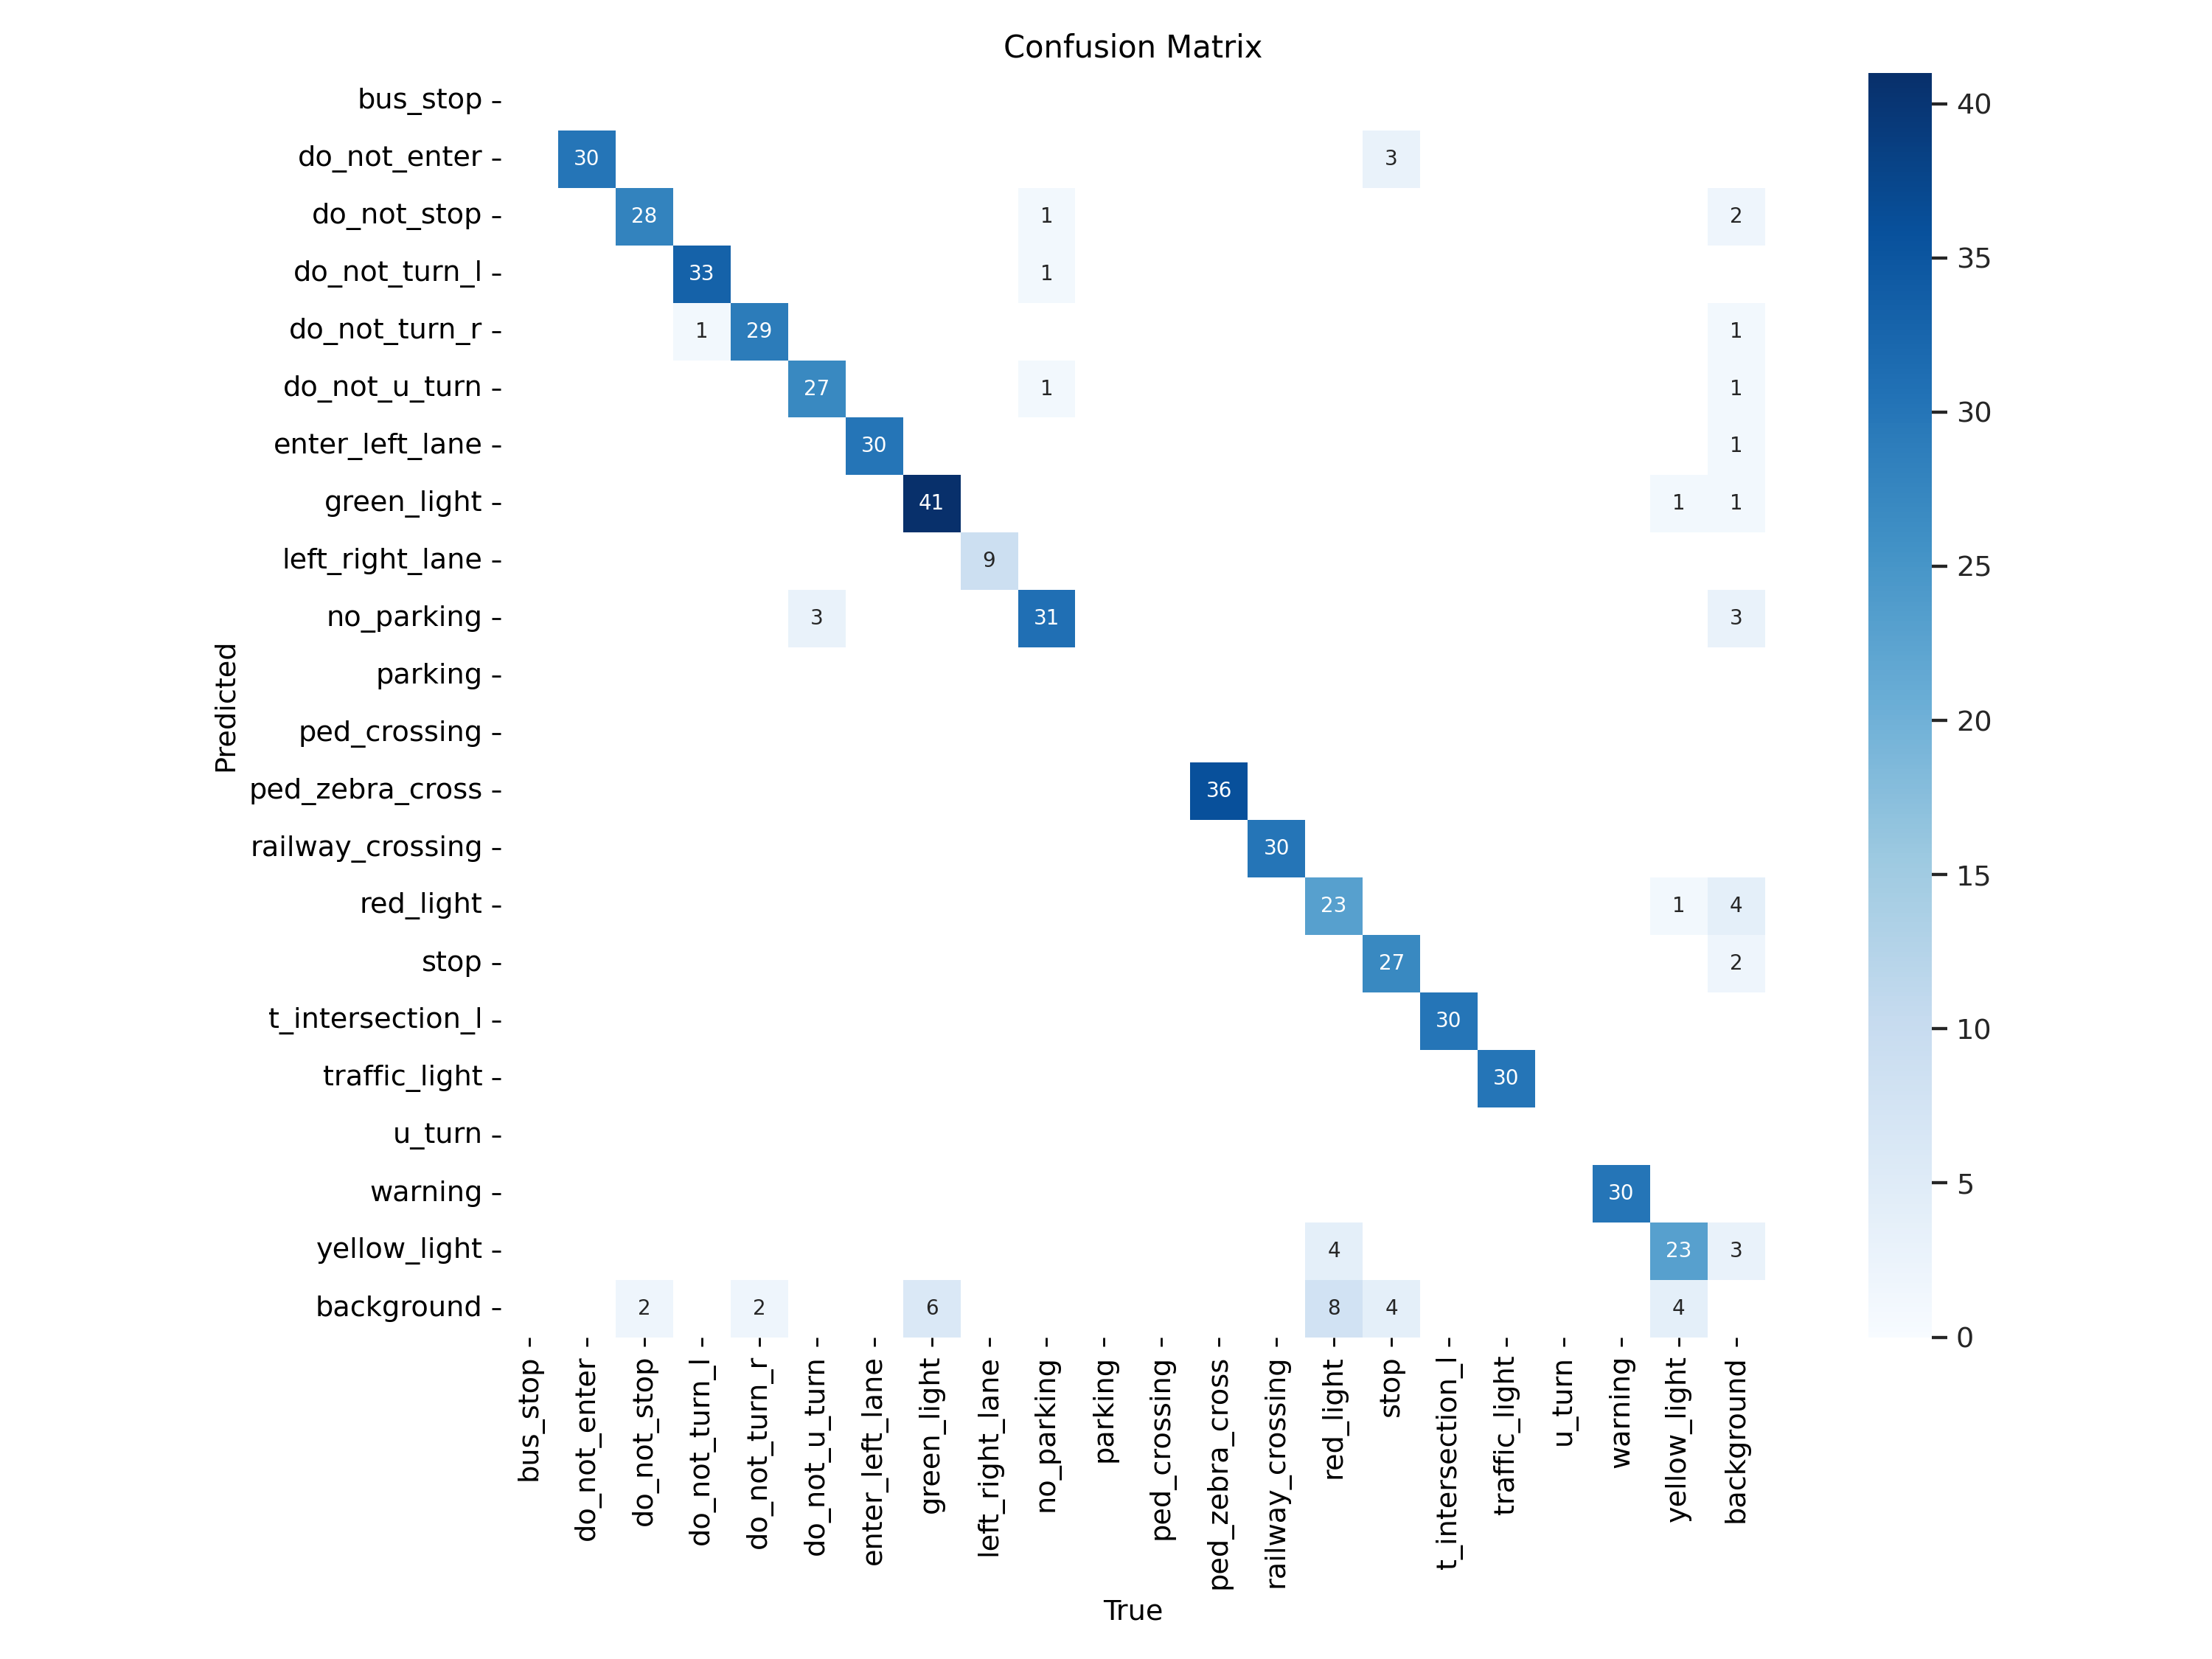

In [14]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=1000)

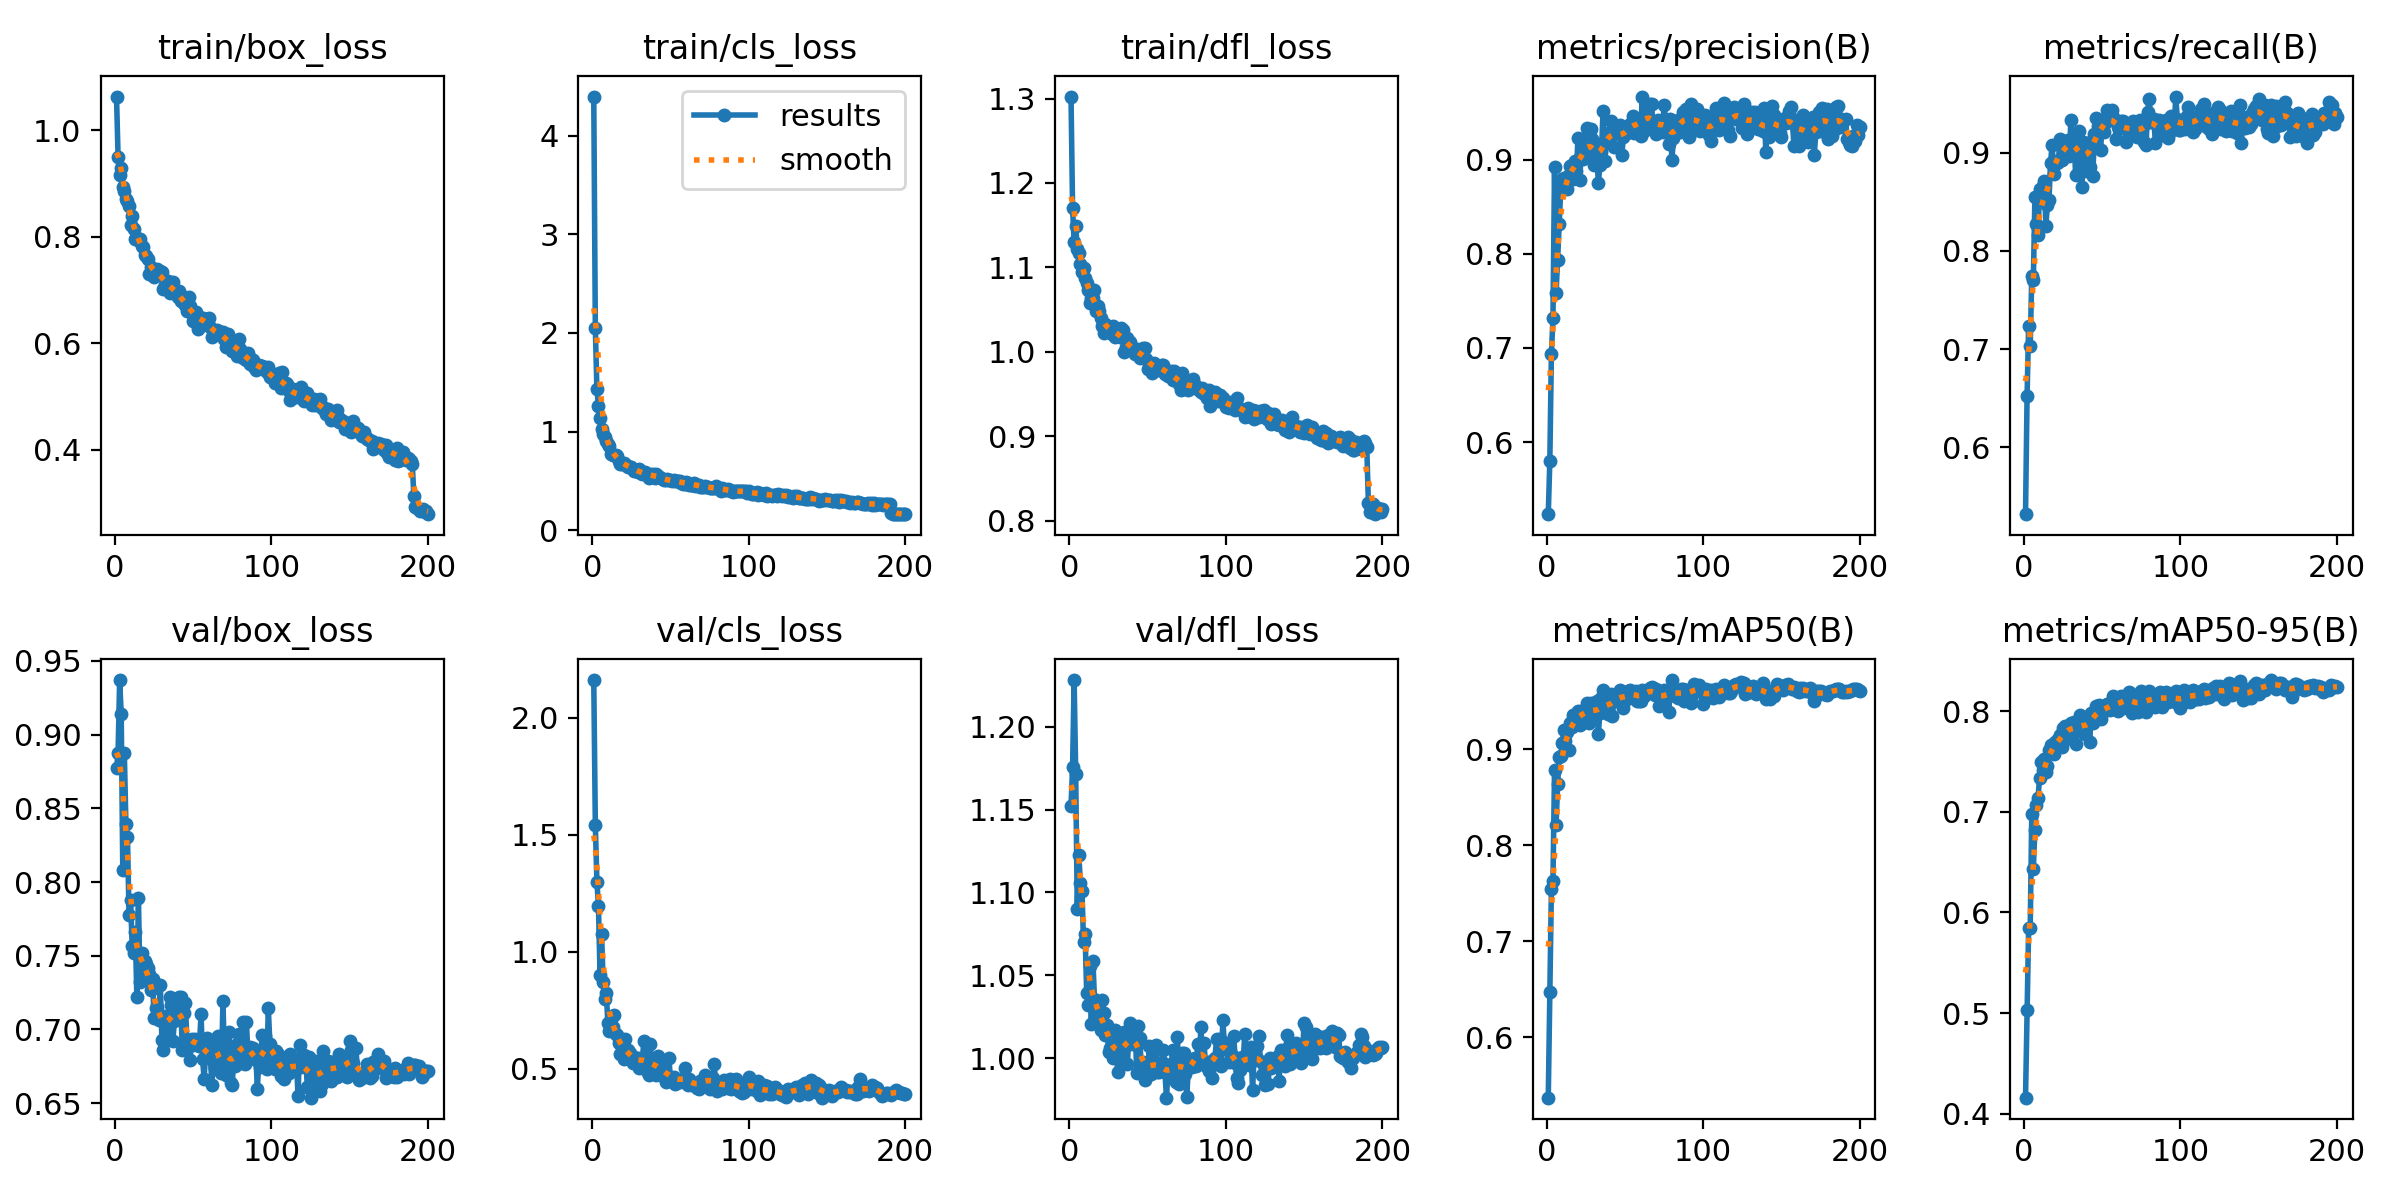

In [15]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/results.png', width=1000)

In [16]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

ds.classes

['bus_stop',
 'do_not_enter',
 'do_not_stop',
 'do_not_turn_l',
 'do_not_turn_r',
 'do_not_u_turn',
 'enter_left_lane',
 'green_light',
 'left_right_lane',
 'no_parking',
 'parking',
 'ped_crossing',
 'ped_zebra_cross',
 'railway_crossing',
 'red_light',
 'stop',
 't_intersection_l',
 'traffic_light',
 'u_turn',
 'warning',
 'yellow_light']

In [17]:
from supervision.metrics import MeanAveragePrecision

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

In [18]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.7469143161986282
mAP 50 0.8773515351090765
mAP 75 0.8560799821083999


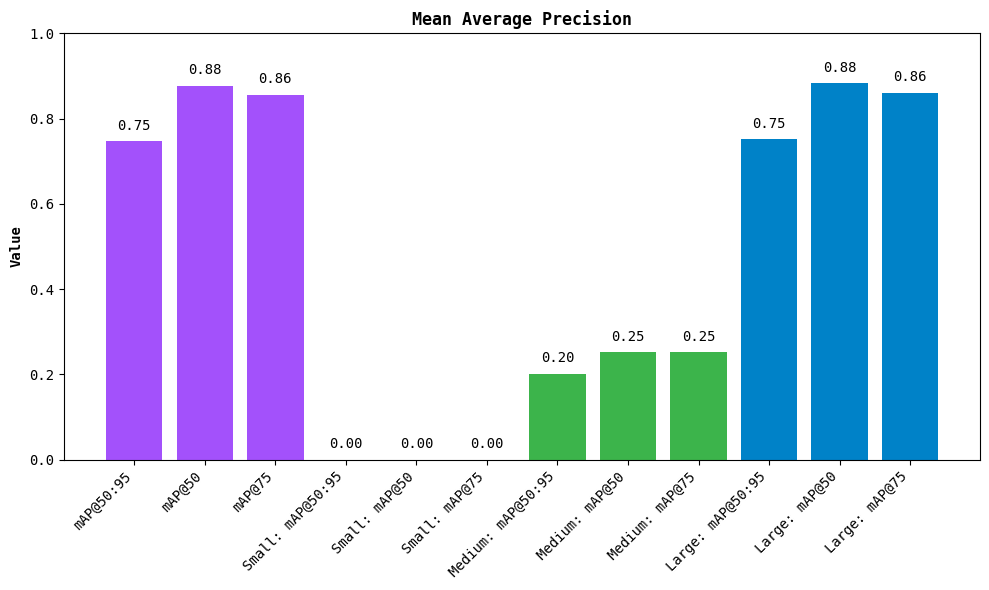

In [19]:
map.plot()


In [20]:
import supervision as sv

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

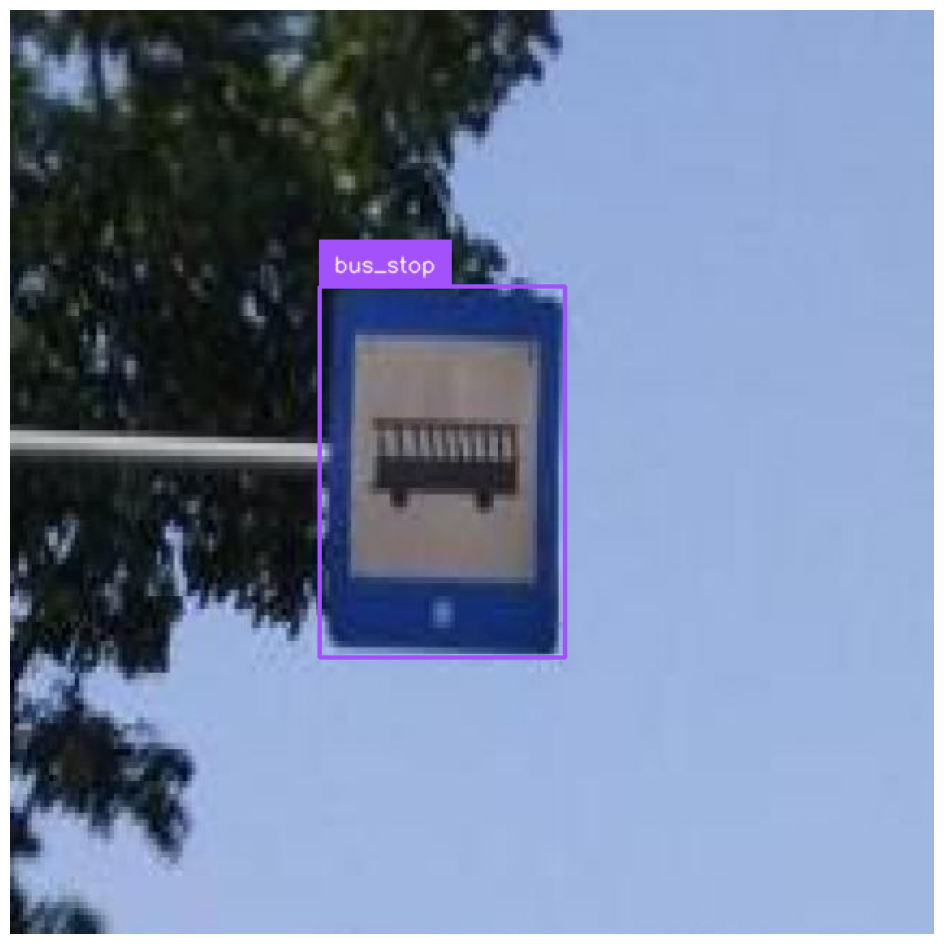

In [21]:
import random

i = random.randint(0, len(ds))

image_path, image, target = ds[i]

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

In [22]:
import shutil
from google.colab import files

# 將 /content/runs 壓縮成 runs.zip
shutil.make_archive('/content/runs', 'zip', '/content/runs')

# 下載 runs.zip
files.download('/content/runs.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>